# **Prob_theta**

##### First we import the necessary packages

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import quad
import math as mt
import cmath as cm
from funcs import *

In [2]:
# We initialize the density matrix of a coherent state (which we want to analyze)

# N is the number of Fock states in our Hilbert space

N = 20

# eig_val is the eigenvalue for our coherent state

eig_val = np.sqrt(2)

rho_coherent_dm = qt.coherent_dm(N, eig_val)

rho_coherent = qt.coherent(N, np.sqrt(2))

In [3]:
type = rho_coherent_dm.dtype

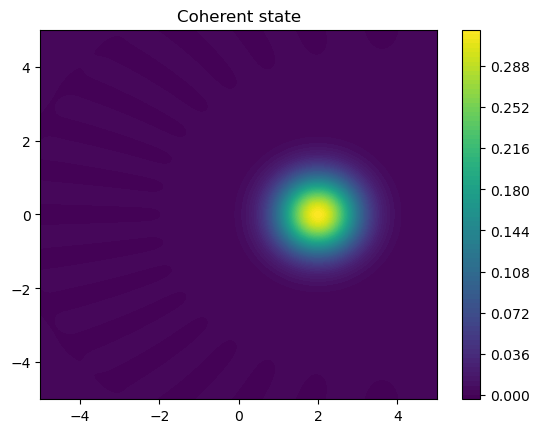

In [4]:
# Below we create the Wigner function using qtip and choose an x-space from -lnspc to with 200 points

lnspc = 5

xvec = np.linspace(-lnspc,lnspc,200)

W_coherent = qt.wigner(rho_coherent_dm, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We define the a rotation function applicable to the density matrix

In [5]:
# Simple rotation function

def rot(theta):
    return (1j*theta*qt.num(N)).expm()

# 1j is just i and rho_coherent is a vector (can be rotated as such)


#### As an example we consider the coherent state rotated by 90 degrees

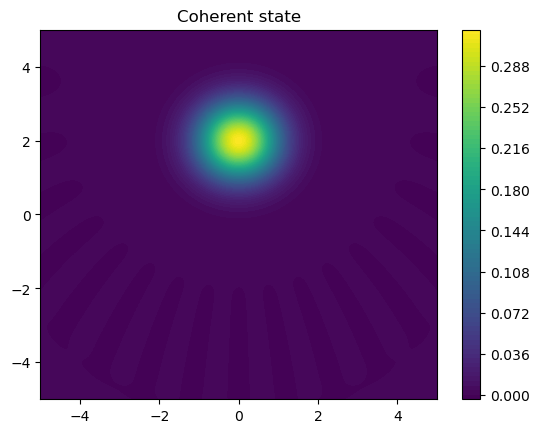

In [6]:
W_coherent = qt.wigner(rot(mt.pi/2)*rho_coherent, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We apply this process for different values of theta, here theta=[0,30,60,90,120,150]

In [7]:
num_thetas = [0,30,60,90,120,150]
thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(thetas)

W_coherents = [0]*N_thetas

# xs contains all the x values for different values of theta

xs = np.zeros((N_thetas,len(W_coherent[0])))

# The for loop below updates the xs array to contain the x-values (int over all p) at different angles

for i in range(N_thetas):
    W_coherents[i] = qt.wigner(rot(thetas[i])*rho_coherent, xvec, xvec)
    cohe = W_coherents[i]
    seq = np.array([np.sum(cohe[:,j]) * (xvec[1]-xvec[0])/20 for j in range(len(W_coherents[0][0]))])
    xs[i] = seq

##### Below, the values of p(x_theta) are shown for the different values of theta

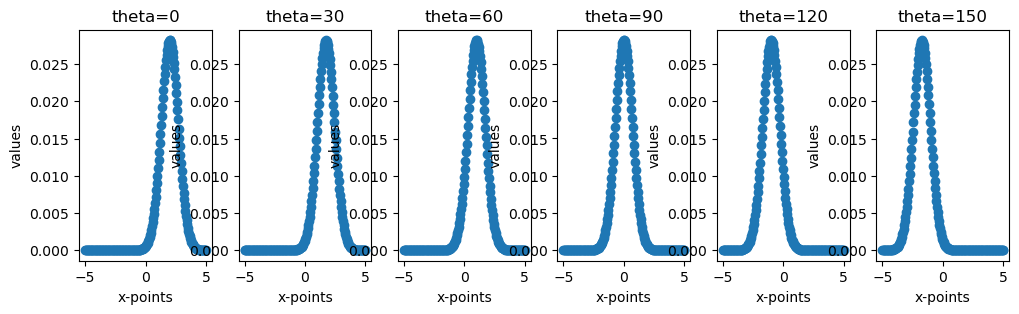

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[0])
scat1 = axes[1].scatter(xvec, xs[1])
scat2 = axes[2].scatter(xvec, xs[2])
scat3 = axes[3].scatter(xvec, xs[3])
scat4 = axes[4].scatter(xvec, xs[4])
scat5 = axes[5].scatter(xvec, xs[5])

i = 0

for ax in axes.flat:
    ax.set(xlabel='x-points', ylabel='values', title='theta=' + str(num_thetas[i]))
    i+=1

plt.show()

##### Now that we have different probability distributions for x we can use the rejection sampling technique

##### Below we plot the random generated sample as well as the sample function

# We define theta_indx below which choose a theta in list [0,30,60,90,120,150]

## **Choose theta to match the rotation you want to examine**

In [9]:
# We can choose which theta in the list we want to examine by changing theta_indx

theta_indx = 0

vals = Rsamp(xs[theta_indx], 5)

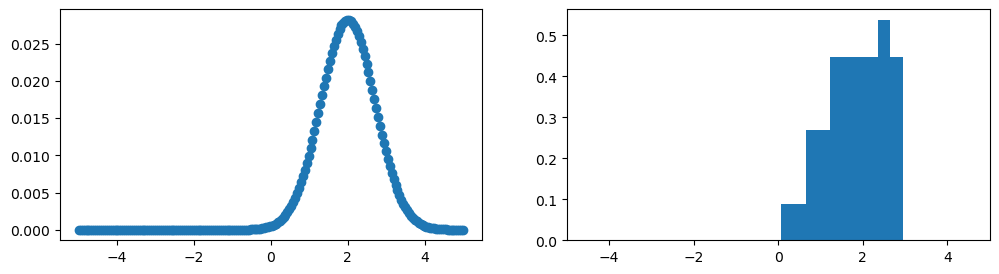

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[theta_indx])
hist1 = axes[1].hist(vals,bins=10, density=True, stacked=True)

plt.xlim(-lnspc,lnspc)
plt.show()

##### We make a random sample for each theta in theta-values {0,30,60,90,120,150}

In [11]:
# Our samples_theta is the list containing the sample for each value of theta

num_thetas = [0,30,60,90,120,150]
rad_thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(num_thetas)

samples_theta = [0] * N_thetas

# Since the length of the array depends on the sample we cannot make samples_theta into a numpy array
# Therefore we keep it as a list for now

# samples_theta contains our random samples

for j in range(N_thetas):
    samples_theta[j] = Rsamp(xs[j], lnspc)

# Creating prjs and fjs for the likelyhood-function

In [12]:
# This makes the density matrix into a numpy array

if rho_coherent_dm.dtype == type:
    rho_coherent_dm = rho_coherent_dm.full()
    rho_coherent_dm = np.real(np.array(rho_coherent_dm))

In [13]:
# We initialize our linspace as 200 points linearly spaced in range -5 to 5

ns = np.arange(20)
xs = np.linspace(-5,5,200)

# Function below returns two (20,200) arrays, one for each type of matrix mult.
NS, XS = np.meshgrid(ns, xs, indexing='ij')

# As we have used @vectorize() decorator we can use tensors(vectors) as input to the overlap function
# Here we give it two arrays of shape (20,200) and the function gives a (20,200) array
my = overlap(NS, 0, XS)
yn = my.copy()
yn = np.conj(yn).T

my.shape, yn.shape

((20, 200), (200, 20))

In [14]:
# Although the einsum function is tricky what we do here is that we give two arrays as input
# of shape (20,200) and (200,20) respectively.

# The einsum function uses incides 'i...,...j'
# We multiply each value of overlap with n for with each value of overlap with m for all y
# meaning that for yn of shape (200,20), we take each column array of (200) values and multiply with
# each row array in my of shape (20,200) which gives us 20 values for the first column of yn

# We then do this for all columns of yn and the result is a matrix of shape (200,20,20)
# corresponding to the projection operator

projs = np.einsum('i...,...j', my, yn)
projs.shape

(200, 20, 20)

##### ***Below are simple checks to confirm that the function above is correct***

In [15]:
# Taking the trace yields the values where m=n

prjs = np.trace(projs @ rho_coherent_dm, axis1=1, axis2=2) * .05 # This is just our prj values
prjs.sum() # They sum up to one

(0.9949999999997585+0j)

In [16]:
xs[87]

-0.6281407035175874

In [17]:
overlap(7, 0, xs[87]) * np.conj(overlap(4, 0, xs[87]))

(0.06426867813566237+0j)

In [18]:
projs[87, 7, 4]

(0.06426867813566237+0j)

In [19]:
# Here we create the fj values as the occurence of each value on the chosen grid

fjs = np.zeros(200)
grid = np.linspace(-5,5,200)
for i in range(len(fjs)):
    if np.isin(grid[i],samples_theta[theta_indx]):
        fjs[i] = 1

## Below; old code that works, but is not as efficient as using the einsum has been commented out

##### With the Likelyhood function we take as input a state operator (in this first case we know the state operator) and compute value. This value is largest (closest to one) for the correct state operator.

In [20]:
# We define theta_indx to be a dynamic variable (choose the sample of theta=0,30,60,90,120,150 by index)

# I should make this a dictionary

#sample = np.histogram(samples_theta[theta_indx],bins=100)

In [21]:
# fjs is our number of occurences

#yjs = sample[1]
#yjs = np.array(yjs)

#fjs = sample[0]
#fjs = np.array(fjs) #These values do not sum to 1!?

# Below we convert the density operator from type Qobj to type numpy-array (if the density operator is of type Qobj)

#if rho_coherent_dm.dtype == type:
#    rho_coherent_dm = rho_coherent_dm.full()
#    rho_coherent_dm = np.real(np.array(rho_coherent_dm))

# What we are doing here is that we are updating yjs to only include the midpoint value
# of each bin which matches the dimension of fvals (i.e. we have the same number of j's)

#for i in range(len(yjs)):
#    if i < len(yjs)-1:
#        yjs[i] = yjs[i] + (yjs[i+1] - yjs[i])/2

#yjs = np.delete(yjs,-1)

# Dimensions of density operator, rho below. In our case the dimension of rho is 20 x 20

#M = rho_coherent_dm.shape[0]
#N = rho_coherent_dm.shape[1]

# This is our prjs; we update this later

#prjs = np.zeros(len(fjs))

##### Old derivation of overlaps (slow; takes app. 17s)

In [22]:
#K = len(prjs)

#for k in range(K):
#    sum = 0
#    for i in range(M):
#        for j in range(N):
#            seq = overlap(i,theta_indx,yjs[k]) * overlap(j,theta_indx,yjs[k]) * rho_coherent_dm[i,j]
#            sum += seq
#    prjs[k] = sum


##### Derivation using matrix multiplication (faster; takes app. 1.6s)

In [23]:
# Matrix multiplication to derive overlaps (much faster)

#K = len(prjs)

#Mnk = CreateMatrixOverlap(N,K,theta_indx,yjs)
#Mkn = CreateMatrixOverlap(K,N,theta_indx,yjs)
#Mkn = np.conjugate(np.transpose(Mnk))

#val = np.dot(rho_coherent_dm,Mnk)
#val = np.dot(Mkn, val)

#for k in range(K):
#    prjs[k] = np.sum(val[k])

In [24]:
# Although the value is low the input values should be correct

L = likelyHood(prjs,fjs)
print('The likelhood value is ' + str(L) + ' whose log value is ' + str(mt.log(L)))

The likelhood value is (3.760014754795513e-80+0j) whose log value is -182.8823845579818


C:\Users\rasmu\AppData\Local\Temp\ipykernel_3032\1279079651.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  print('The likelhood value is ' + str(L) + ' whose log value is ' + str(mt.log(L)))


### Changing the sample generated (by changing theta_indx) changes the likelyhood. If we keep the unrotated density operator and use rotated sample values we get lower (more unlikely) values.

### After checking that the likelyhood function works we can move on to maximization of likelyhood of a 'guessed' density operator

# Ensemble that maximizes the likelyhood, maxLik

In [25]:
def DivideElement(arr1,arr2):
    M = np.ones(len(arr1))

    for i in range(len(arr1)):
        M[i] = arr1[i]/arr2[i]
    return M

#arrHelp = [0] * N

#for i in range(N):
#    arrHelp[i] = DivideElement(Mnk[i],prjs)

#Mnk = arrHelp
#Mkn = np.conjugate(np.transpose(Mnk))

In [26]:
projs.shape

(200, 20, 20)

In [27]:
thetaOp = [0]*len(thetas)

ns = np.arange(20)
xs = np.linspace(-5,5,200)

# Function below returns two (20,200) arrays, one for each type of matrix mult.
NS, XS = np.meshgrid(ns, xs, indexing='ij')

for indx in range(len(thetas)):
    # As we have used @vectorize() decorator we can use tensors(vectors) as input to the overlap function
    # Here we give it two arrays of shape (20,200) and the function gives a (20,200) array
    my = overlap(NS, indx, XS)
    yn = my.copy()
    yn = np.conj(yn).T

    my.shape, yn.shape
    thetaOp[indx] = np.einsum('i...,...j', my, yn)

thetaOp = np.array(thetaOp)

In [28]:
thetaOp.shape

(6, 200, 20, 20)

In [29]:
prjsTheta = [0]*len(thetas)

for indx in range(len(thetas)):
    prjsTheta[indx] = np.trace(thetaOp[indx] @ rho_coherent_dm, axis1=1, axis2=2)

prjsTheta = np.array(prjsTheta)

In [30]:
prjsTheta.shape

(6, 200)

In [31]:
# This is eq. (10) in Lvovsky

def opR(proj,prjsFull):
    operatorR = np.zeros((20,20))

    for indx in range(len(thetas)):
        for x in range(len(prjs)):
            operatorR = np.add(operatorR,proj[indx,x] / prjsFull[indx,x])
    return operatorR

In [32]:
opR(thetaOp,prjsTheta).shape

(20, 20)

### Next step is to include the interative optimization of rho, eq. (5) in Lvovsky